# Implementation for Generative Adveserial Networks (GANs)
Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio
https://arxiv.org/abs/1406.2661


### Simple example for MNIST images

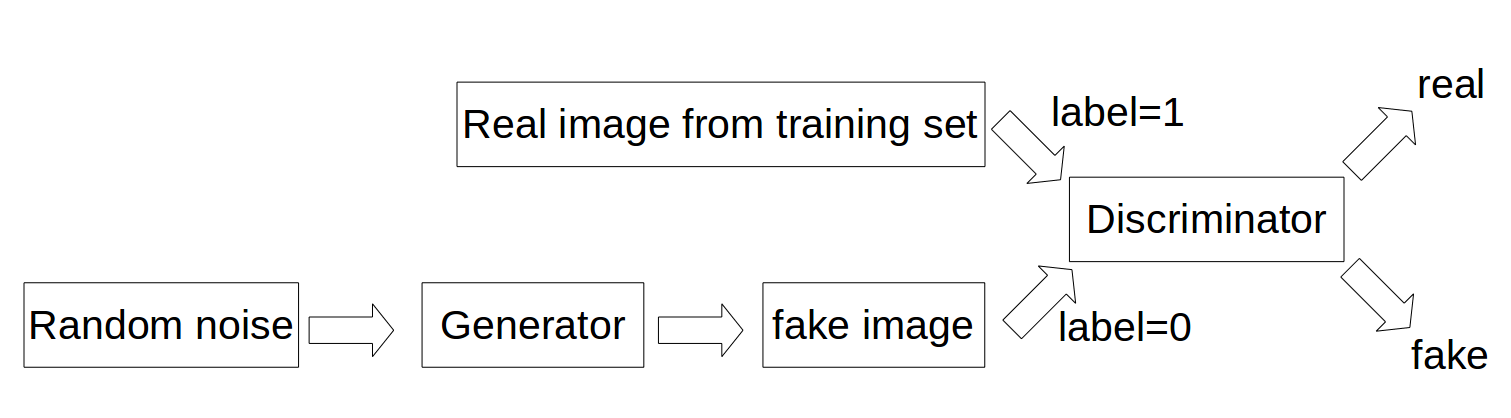

In [1]:
from IPython.display import Image
Image("notebook_imgs/gan_network_structure.png", retina=True)

In [ ]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import deque

plt.switch_backend('agg')   # allows code to run without a system DISPLAY

width=28
height=28
channels=1
shape = (width, height, channels)
optimizer = Adam(lr=0.0001, beta_1=0.5, decay=1e-8)
gen_loss_list = deque(maxlen=500)
dis_loss_list = deque(maxlen=500)

def create_generator(): #  maps from 100 random numbers to a synthetic image
    model = Sequential()
    model.add(Dense(256, input_shape=(100,)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(width  * height * channels, activation='tanh'))
    model.add(Reshape((width, height, channels)))
    return model

generator = create_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

def create_discriminator(): # classifies if it is a synthetic or real image
    model = Sequential()
    model.add(Flatten(input_shape=shape))
    model.add(Dense((width * height * channels), input_shape=shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense( int((width * height * channels)/2) ))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

def stacked_generator_discriminator():
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

stacked_generator_discriminator = stacked_generator_discriminator()
stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

def train(X_train, num_epochs=15000, batch = 32, save_interval = 500):
    for epoch in range(num_epochs):
        ## train discriminator
        random_index = np.random.randint(0, len(X_train) - batch/2)
        legit_images = X_train[random_index : random_index + int(batch/2)].reshape(int(batch/2), width, height, channels)

        gen_noise = np.random.normal(0, 1, (int(batch/2), 100))
        syntetic_images = generator.predict(gen_noise)

        x_combined_batch = np.concatenate((legit_images, syntetic_images))
        y_combined_batch = np.concatenate((np.ones((int(batch/2), 1)), np.zeros((int(batch/2), 1)))) # labels for the first half --> legit images, second half --> fakes

        d_loss = discriminator.train_on_batch(x_combined_batch, y_combined_batch)
        dis_loss_list.append(d_loss[0])


        # train generator
        noise = np.random.normal(0, 1, (batch, 100))
        y_mislabled = np.ones((batch, 1))

        g_loss = stacked_generator_discriminator.train_on_batch(noise, y_mislabled)
        gen_loss_list.append(g_loss)

        if((epoch % 500) == 0):
            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (epoch, np.mean(dis_loss_list), np.mean(gen_loss_list)))

        if epoch % save_interval == 0:
            plot_images(save2file=True, step=epoch)


def plot_images(save2file=False, samples=16, step=0):
    filename = "./generator_images/mnist_%d.png" % step
    noise = np.random.normal(0, 1, (samples, 100))

    images = generator.predict(noise)

    plt.figure(figsize=(10, 10))

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()

    if save2file:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3) # adds an additional dimension

train(X_train)


# GANs to create images of cats and dogs

get the dataset from: https://www.kaggle.com/c/dogs-vs-cats/data
and extract it into a folder with the same path as this notebook <br>
the folder structure should look like this: <br>
 /GAN_implementation.ipynb <br>
 /generator_images/ <br>
 /dogs-vs-cats <br>
 /dogs-vs-cats/test1 <br>
 /dogs-vs-cats/train <br>
 /dogs-vs-cats/sampleSubmission.csv

# Cats and Dogs with a 28 x 28 x 1 resulution

In [ ]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Activation, Conv2D, MaxPooling2D 
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import deque
import os
from PIL import Image
import cv2
from sklearn.metrics import accuracy_score
from skimage import io, transform
from collections import deque

plt.switch_backend('agg')

width=28
height=28
channels=1
shape = (width, height, channels)
optimizer = Adam(lr=0.0001, beta_1=0.5, decay=1e-8)
gen_loss_list = deque(maxlen=500)
dis_loss_list = deque(maxlen=500)

def create_generator(): #  maps from 100 random numbers to a synthetic image
    model = Sequential()
    model.add(Dense(245, input_shape=(100,)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Reshape((7, 7, 5)))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D((2, 2))) # 14x14
    
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(16, (3,3), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D((2, 2)))
    
    model.add(Conv2D(16, (3,3), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (3,3), padding='same', activation='tanh'))
    

    return model

generator = create_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

def create_discriminator():
    cnn = Sequential()
    cnn.add(Conv2D(64, (3,3), input_shape = shape, padding='same', activation = 'relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(Conv2D(128, (3,3), padding='same', activation = 'relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(Flatten())
    cnn.add(Dense(512, activation = 'relu'))
    cnn.add(Dense(1, activation = 'sigmoid'))
    cnn.summary
    return cnn

discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

def stacked_generator_discriminator():
    discriminator.trainable = False # wieso?
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

stacked_generator_discriminator = stacked_generator_discriminator()
stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

def train(X_train, num_epochs=15000, batch = 32, save_interval = 500):
    for epoch in range(num_epochs):
        ## train discriminator
        random_index = np.random.randint(0, len(X_train) - batch/2)
        legit_images = X_train[random_index : random_index + int(batch/2)].reshape(int(batch/2), width, height, channels)

        gen_noise = np.random.normal(0, 1, (int(batch/2), 100))
        syntetic_images = generator.predict(gen_noise)

        x_combined_batch = np.concatenate((legit_images, syntetic_images))
        y_combined_batch = np.concatenate((np.ones((int(batch/2), 1)), np.zeros((int(batch/2), 1)))) # labels for the first half --> legit images, second half --> fakes

        d_loss = discriminator.train_on_batch(x_combined_batch, y_combined_batch)
        dis_loss_list.append(d_loss[0])


        # train generator
        noise = np.random.normal(0, 1, (batch, 100))
        y_mislabled = np.ones((batch, 1))

        g_loss = stacked_generator_discriminator.train_on_batch(noise, y_mislabled)
        gen_loss_list.append(g_loss)

        if((epoch % 500) == 0):
            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (epoch, np.mean(dis_loss_list), np.mean(gen_loss_list)))

        if epoch % save_interval == 0:
            plot_images(save2file=True, step=epoch)


def plot_images(save2file=False, samples=16, step=0):
    filename = "./generator_images/cats_dogs_%d.png" % step
    noise = np.random.normal(0, 1, (samples, 100))

    images = generator.predict(noise)

    plt.figure(figsize=(10, 10))

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()

    if save2file:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()


def reshaped_image(image):
    return transform.resize(image,(width, height, 3))

def load_images_from_folder():
    Images = os.listdir("./dogs-vs-cats/train/")
    train_images = []
    for image in Images: # iterates over all file names
            if image.find('cat') != -1:
                path = os.path.join("./dogs-vs-cats/train/", image)
                img = cv2.imread(path)
                train_images.append(reshaped_image(img))
            if image.find('dog') != -1:
                path = os.path.join("./dogs-vs-cats/train/", image)
                img = cv2.imread(path)
                train_images.append(reshaped_image(img))
    return np.array(train_images)


X_train = load_images_from_folder()
X_train = (X_train.astype(np.float32))
        
# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 0.5) / 0.5
X_train = X_train[:,:,:,0]
X_train = np.expand_dims(X_train, axis=3) # adds an additional dimension

train(X_train)


# Cats and Dogs with a 56 x 56 x 1 resulution
### still quite unstable

In [ ]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Activation, Conv2D, MaxPooling2D 
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import deque
import os
from PIL import Image
import cv2
from sklearn.metrics import accuracy_score
from skimage import io, transform
from collections import deque

plt.switch_backend('agg')

width=56
height=56
channels=1
shape = (width, height, channels)
optimizer = Adam(lr=0.00003, beta_1=0.5, decay=1e-10)
gen_loss_list = deque(maxlen=500)
dis_loss_list = deque(maxlen=500)

def create_generator(): #  maps from 100 random numbers to a synthetic image
    model = Sequential()
    model.add(Dense(245, input_shape=(100,)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Reshape((7, 7, 5)))

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D((2, 2))) # 14x14
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D((2, 2))) # 28x28
    
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D((2, 2))) # 56x56
    
    model.add(Conv2D(16, (3,3), padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (3,3), padding='same', activation='tanh'))
    

    return model

generator = create_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

def create_discriminator():
    cnn = Sequential()
    cnn.add(Conv2D(64, (3,3), input_shape = shape, padding='same', activation = 'relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(Conv2D(128, (3,3), padding='same', activation = 'relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    cnn.add(Flatten())
    cnn.add(Dense(512, activation = 'relu'))
    cnn.add(Dense(1, activation = 'sigmoid'))
    cnn.summary
    return cnn

discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

def stacked_generator_discriminator():
    discriminator.trainable = False # wieso?
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

stacked_generator_discriminator = stacked_generator_discriminator()
stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

def train(X_train, num_epochs=100000, batch = 32, save_interval = 2000):
    for epoch in range(num_epochs):
        ## train discriminator
        random_index = np.random.randint(0, len(X_train) - batch/2)
        legit_images = X_train[random_index : random_index + int(batch/2)].reshape(int(batch/2), width, height, channels)

        gen_noise = np.random.normal(0, 1, (int(batch/2), 100))
        syntetic_images = generator.predict(gen_noise)

        x_combined_batch = np.concatenate((legit_images, syntetic_images))
        y_combined_batch = np.concatenate((np.ones((int(batch/2), 1)), np.zeros((int(batch/2), 1)))) # labels for the first half --> legit images, second half --> fakes

        d_loss = discriminator.train_on_batch(x_combined_batch, y_combined_batch)
        dis_loss_list.append(d_loss[0])


        # train generator
        noise = np.random.normal(0, 1, (batch, 100))
        y_mislabled = np.ones((batch, 1))

        g_loss = stacked_generator_discriminator.train_on_batch(noise, y_mislabled)
        gen_loss_list.append(g_loss)

        if((epoch % 1000) == 0):
            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (epoch, np.mean(dis_loss_list), np.mean(gen_loss_list)))

        if epoch % save_interval == 0:
            plot_images(save2file=True, step=epoch)


def plot_images(save2file=False, samples=16, step=0):
    filename = "./generator_images/cats_dogs_%d.png" % step
    noise = np.random.normal(0, 1, (samples, 100))

    images = generator.predict(noise)

    plt.figure(figsize=(10, 10))

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()

    if save2file:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()


def reshaped_image(image):
    return transform.resize(image,(width, height, 3))

def load_images_from_folder():
    Images = os.listdir("./dogs-vs-cats/train/")
    train_images = []
    for image in Images: # iterates over all file names
            if image.find('cat') != -1:
                path = os.path.join("./dogs-vs-cats/train/", image)
                img = cv2.imread(path)
                train_images.append(reshaped_image(img))
            
            if image.find('dog') != -1:
                path = os.path.join("./dogs-vs-cats/train/", image)
                img = cv2.imread(path)
                train_images.append(reshaped_image(img))
            
    return np.array(train_images)


X_train = load_images_from_folder()
X_train = (X_train.astype(np.float32))
        
# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 0.5) / 0.5
X_train = X_train[:,:,:,0]
X_train = np.expand_dims(X_train, axis=3) # adds an additional dimension

train(X_train)


### plots a Sample image of the training set

In [ ]:
%matplotlib inline
image = X_train[8,:,:,0]
plt.imshow(image, cmap='gray')
plt.show()